# Homework 3: GPT-OSS-20B Transformer Architecture

During classes, we discussed the general idea of Transformer blocks and their role in modern language models. In this homework, we will go step by step through a modern decoder-only transformer block, specifically examining the architecture of the GPT-OSS-20B model recently released by OpenAI. You will implement key components of this architecture and train the model using the language modeling objective.

The assignment is worth the total of 15 points and its tasks are divided into two parts: implementation (located in Part 2 of this notebook, worth 9 points) and work with data (located in Part 3 of this notebook, worth 6 points).

### Deliverables
On Moodle, submit a .zip archive with:

* Notebook (.ipynb):
  * It should contain:
    * An implementation of the modified GPT-OSS-20B architecture according to the description in Part 1 and structure in Part 2.
    * Data processing according to the description in Part 3.
      It should be possible to execute the whole notebook start-to-end without human intervention.
    * Do not modify (but do execute) cells with the code starting with a comment that contains tag [do not modify]. If you wish to extend them (e.g. to check more GradCAM results), you may do so under a new header.
    * Report as a series of cells after the heading `Your report`.
* All additional files (e.g. figures you refer to in the report part) that are linked from the notebook.


Link to Colab version of the notebook for fast replication.

## Part 1: Description of the Architecture

In this section, we will implement the decoder-only architecture used in modern transformer-based language models. You will build the specific architecture of the slightly modified GPT-OSS-20B model, going through each component step by step.

To understand the foundations, you can refer to the original Transformer paper: [Attention Is All You Need](https://arxiv.org/abs/1706.03762).

For this homework, you will implement the GPT-OSS-20B architecture as described by Sebastian Raschka in [his detailed blog post](https://magazine.sebastianraschka.com/p/from-gpt-2-to-gpt-oss-analyzing-the), which analyzes the evolution from GPT-2 to modern transformer architectures.


### Brief Description of the Transformer Pipeline

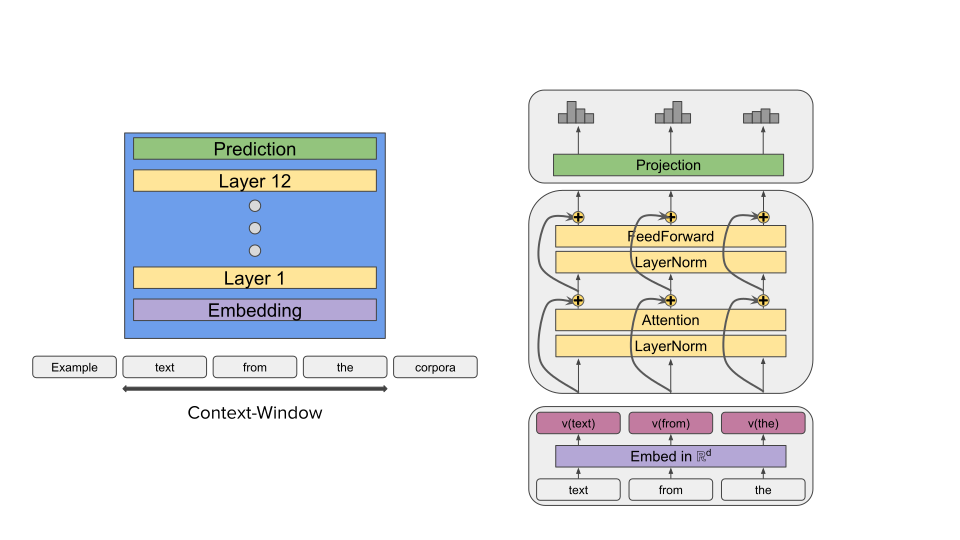


#### The Input
Input to the transformer model is a sequence of tokens, with the sequence length bounded by the model's context size.

**Tokens** can correspond to individual characters, words, or subword units, and are represented as integers. A **tokenizer** converts raw text into token sequences. For example, applying a [GPT-style tokenizer](https://platform.openai.com/tokenizer) to the word `habitat` produces three tokens `[5976, 270, 265]` corresponding to `["hab", "it", "at"]`. Modern tokenizers typically use vocabularies of around 128k tokens. You can learn more about tokenization [here](https://huggingface.co/docs/transformers/tokenizer_summary).

#### The Output

For each input position, the transformer outputs a probability distribution over the next token conditioned on all previous tokens. For instance, given the token sequence `["hab", "it", "at"]`, the model computes $\mathbb{P}(t_3 \mid t_1=\text{hab}, t_2=\text{it})$ for the third position.

Formally, if we denote the transformer function as $T$ and tokens as $t_i$ for $i \in \{1, \ldots, n\}$, then $T(t_i) = \mathbb{P}(t_{i+1} \mid t_1, \ldots, t_i)$, where $\mathbb{P}$ approximates the distribution of the training data.

#### Transformer Processing Pipeline - Overview

The diagram below illustrates the processing flow:

The pipeline consists of the following stages:

1. **Token Embedding**: Each input token is converted to a dense vector using an embedding matrix of shape `(vocab_size, hidden_dim)`. Initially random, these embeddings learn to capture *semantic meaning* during training.

2. **Transformer Blocks**: The embedded tokens pass through multiple transformer layers. Each layer contains two main components:
   - **Self-Attention**: Allows each token to attend to all preceding tokens in the sequence
   - **Feed-Forward Network**: An MLP that independently transforms each token's representation

   Both sublayers use pre-normalization (LayerNorm applied before the sublayer) and residual connections (adding the input directly to the sublayer output).

3. **Output Projection**: After processing through all layers, each token representation is linearly projected to vocabulary size and passed through softmax to produce a probability distribution over the next token.

**Key observation**: Except for the attention mechanism, all operations process each token independently. Only the self-attention layer enables information exchange between tokens, specifically allowing each position to incorporate information from all previous positions.

### Architecture of GPT-OSS-20B
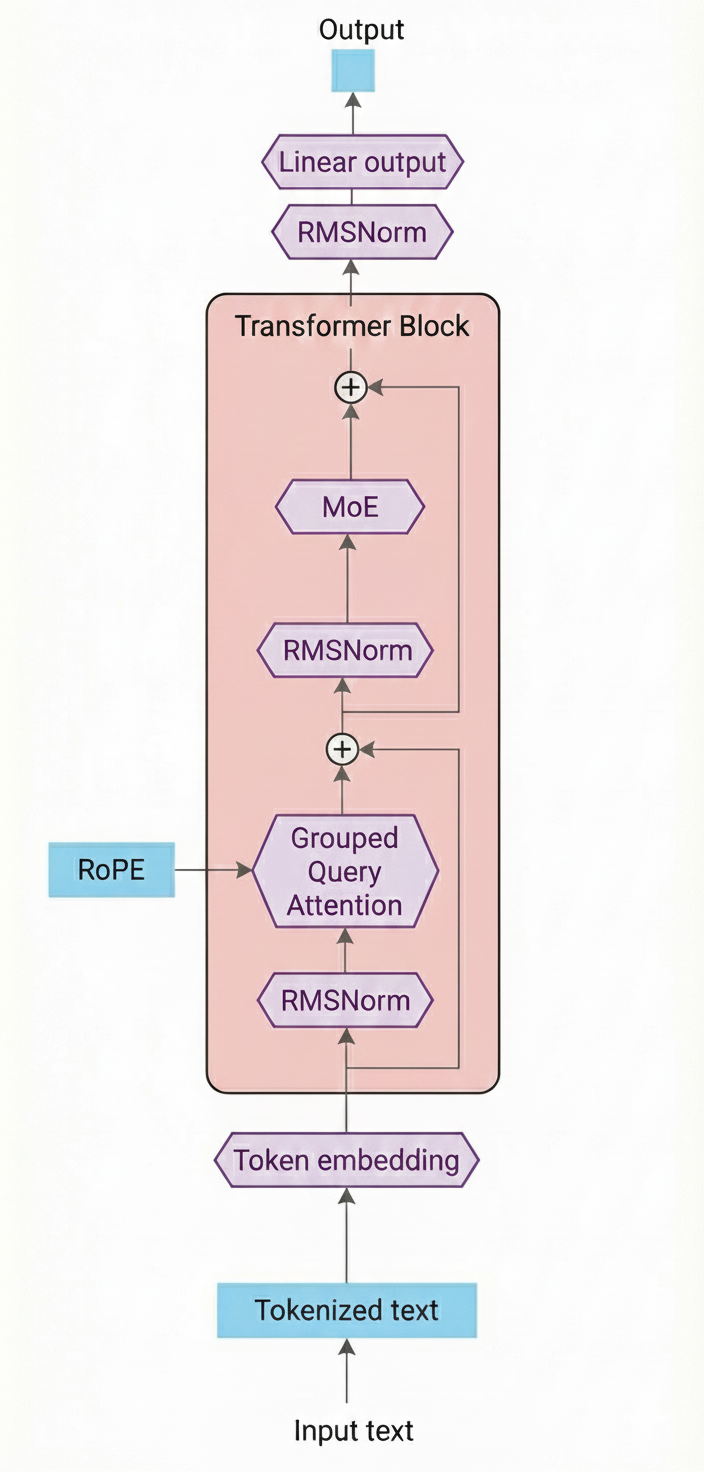


The GPT-OSS-20B architecture follows the general transformer pipeline but introduces several key modifications:

* **Grouped Query Attention (GQA)** replaces standard multi-head attention by sharing key and value projections across multiple heads.
* **Mixture of Experts (MoE)** replaces a single large feed-forward network with multiple specialized smaller networks that process tokens in parallel.
* **RMSNorm** replaces the original LayerNorm, which centers distributions by subtracting the mean, this kind of centering is not used here.
* **Rotary Positional Embedding (RoPE)** replaces standard positional encodings.
* **SwiGLU activation** replaces the standard ReLU-based feed-forward network with a gated linear unit that uses three projections and the SiLU (Sigmoid Linear Unit) activation function.

Additionally, the model applies **Sliding Window Attention** to every second transformer block.

In this assignment, we implement the GPT-OSS-20B architecture with slight modifications to the Grouped Query Attention and Mixture of Experts modules. For RMSNorm, we use PyTorch's built-in implementation. Below, we describe each component in detail and explain the required modifications.

### Grouped Query Attention

Traditional **Multi-Head Attention** uses independent attention heads that capture different aspects of the input sequence (e.g., one head might focus on syntax while another focuses on punctuation). Each head $i$ learns three projection matrices and projects the input into a triple $\langle Q_i, K_i, V_i \rangle$, computing:

$$
\mathit{result}_i = \mathit{softmax}\left(\frac{Q_i \cdot K_i^T}{\sqrt{d_k}}\right) \cdot V_i
$$

where $d_k$ is the dimension of the key (and query) vectors.

**Grouped Query Attention** reduces model size by sharing key and value projections across groups of heads. Each head $i$ is assigned to a group $g(i)$, yielding:

$$
\mathit{result}_i = \mathit{softmax}\left(\frac{Q_i \cdot K_{g(i)}^T}{\sqrt{d_k}}\right) \cdot V_{g(i)}
$$

**Your Task**: Implement a modified version where each head $i$ uses an additional learnable scalar weight $w_i$ applied to the key projection:

$$
\mathit{result}_i = \mathit{softmax}\left(\frac{Q_i \cdot (w_i  K_{g(i)})^T}{\sqrt{d_k}}\right) \cdot V_{g(i)}
$$

This is a simplified variant of [Weighted Grouped Query Attention](https://arxiv.org/pdf/2407.10855).


### Mixture of Experts

We implement the **Mixtral of Experts** architecture (see [the original paper](https://arxiv.org/abs/2401.04088)). Instead of a single feed-forward layer, we use multiple (typically 8) specialized feed-forward networks called "experts." Each expert uses the **SwiGLU** activation function, described later in detail.

A **router** (or gating network) determines which experts process each token. The router outputs weights that combine the expert outputs:

$$
\text{output} = \sum_{i=1}^n G(x)_i \cdot E_i(x)
$$

where:
- $E_1, \ldots, E_n$ are the expert networks
- $G(x)$ is the router function that outputs a weight vector
- $G(x)_i$ is the weight for expert $i$

In Mixtral, the router is sparse, activating only the top-$k$ experts:

$$
G(x) = \text{softmax}(\text{TopK}(x \cdot W_g))
$$

where $\text{TopK}$ retains only the $k$ highest values and sets others to zero. This approach increases model capacity while keeping computational costs manageable.

### Rotary Positional Embedding (RoPE)

Standard attention mechanisms are position-agnostic (position of token doesn't matter). Therefore, positional information must be encoded in the model. The original Transformer architecture computed positional embeddings and added them directly to token embeddings. While this approach encodes position, it has significant limitations:

1. **Fixed sequence length**: There is a hard bound on the number of positions that can be encoded, limiting the context window
2. **Lack of relative position awareness**: The embedding doesn't naturally capture relative distances between tokens. For instance, when reading text, the difference between positions 5 and 6 is perceptually much more significant than the difference between positions 5 and 55

Modern architectures use **Rotary Positional Embedding (RoPE)**, which treats token embeddings as vectors and applies rotations proportional to token position. For a 2D vector at position $m$ with angle parameter $\theta$:

$$
r(x_m, m) = \begin{pmatrix}
\cos(m\theta) & -\sin(m\theta) \\
\sin(m\theta) & \cos(m\theta)
\end{pmatrix}
\begin{pmatrix}
(x_m)_1 \\
(x_m)_2
\end{pmatrix}
$$

where $(x_m)_1$ and $(x_m)_2$ are the coordinates of vector $x_m$.

For higher (even) dimensions, the vector is divided into 2D chunks, and each chunk is rotated independently. Specifically:
- Coordinates 1 and 2 are grouped and rotated together.
- Coordinates 3 and 4 are grouped and rotated together.
- And so on for all coordinate pairs.

Each pair typically uses a different rotation frequency $\theta_i$, allowing the model to capture positional information at multiple scales.

**Key difference from standard positional encoding**: Unlike traditional approaches where positional information is added at the input layer, RoPE applies rotations within the attention mechanism itself, specifically to the query ($Q$) and key ($K$) vectors before computing attention scores. This ensures that positional information is naturally incorporated into the similarity computation between tokens.


### Sliding Window Attention

Sliding Window Attention was proposed in the [Longformer paper](https://arxiv.org/abs/2004.05150) as a method to improve computational efficiency while maintaining model performance.

In standard causal attention, each token can attend to all previous tokens in the sequence. This is implemented through masking: future tokens are masked out by setting their attention scores to $-\infty$ before applying the softmax function. This ensures that during training and inference, the model can only use information from tokens that appear earlier in the sequence, preserving the autoregressive property.

The complete attention formula with causal masking is:

$$
\mathit{result} = \mathit{softmax}\left(M \odot \frac{Q \cdot K^T}{\sqrt{d_k}}\right) \cdot V
$$

where $M$ is a lower triangular matrix with ones below the diagonal and $-\infty$ elsewhere. The $\odot$ operator denotes element-wise multiplication.

**Sliding Window Attention** takes this concept further by restricting the attention window to only the most recent $k$ tokens, rather than all previous tokens. In GPT-OSS-20B, this window size is set to $k=128$. This modification serves two purposes:

1. **Computational efficiency**: By limiting attention to a fixed-size window, the attention complexity becomes linear in sequence length rather than quadratic
2. **Inductive bias**: In many language modeling tasks, the most relevant context for predicting the next token comes from the immediate vicinity rather than distant tokens

In this approach, the mask matrix $M$ is modified to create a "sliding diagonal band." For each row $i$, only a limited number of positions (at most $k$) are set to ones, specifically the positions $\max(0, i-k), \ldots, i$. All positions outside this window are set to $-\infty$, effectively preventing the model from attending to tokens that are too far in the past.

This creates a band matrix structure where each token can only attend to itself and up to $k$ previous tokens, significantly reducing memory and computational requirements while maintaining strong performance on most language modeling tasks.

### SwiGLUFeedForward

The **SwiGLU** activation function, introduced in [this paper](https://arxiv.org/abs/2002.05202v1), is a gated variant of the standard feed-forward layer that has shown improved performance in language modeling tasks.

**Architecture**: Unlike the standard feed-forward network that uses two linear transformations with an activation function in between, SwiGLU employs three linear projections:
- $W_1, V: \mathbb{R}^{d_{\text{hidden}}} \rightarrow \mathbb{R}^{d_{\text{inner}}}$ (two parallel projections)
- $W_2: \mathbb{R}^{d_{\text{inner}}} \rightarrow \mathbb{R}^{d_{\text{hidden}}}$ (output projection)

**Forward Pass**: Given input $x$, the layer computes:

$$
\begin{align*}
h_1 &= W_1(x) \\
h_v &= V(x) \\
h_2 &= \text{SiLU}(h_1) \odot h_v \\
\text{result} &= W_2(h_2)
\end{align*}
$$

where $\text{SiLU}(x) = x \cdot \sigma(x)$ is the Sigmoid Linear Unit (equivalent to Swish with $\beta=1$ in PyTorch), and $\odot$ denotes element-wise multiplication.

**Key Insight**: The gating mechanism ($h_1$ gated by $h_v$) allows the network to control information flow dynamically. The SiLU activation provides smooth, non-monotonic gradients that facilitate training, while the element-wise multiplication with $h_v$ introduces a learnable gating pattern that can selectively amplify or suppress different features.

This feed-forward variant is used as the expert network $E_i(x)$ in the Mixture of Experts implementation described earlier.

## Part 2: Implementation of the Architecture (total 9 points)

In [1]:
#[do not modify]

import torch
import torch.nn.functional as F
from typing import Optional, Callable

from src.execution.TokenChoiceStrategy import TokenChoiceAdvanced

### SwiGluFeedForward (1 point)

In [2]:
# implementaion moved to src/modules/SwiGluFeedForward.py
from src.modules.SwiGLUFeedForward import SwiGLUFeedForward

### Rotary Positional Embedding (RoPE, 1 point)

In [3]:
from src.modules.RotaryPositionalEmbedding import RotaryPositionalEmbedding


# implementation moved to src/modules/RotaryPositionalEmbedding.py

##### TESTS START #####

@torch.no_grad()
def test_rope() -> None:
    """Test RoPE applies correct rotations."""

    head_dim = 4
    max_seq_len = 8
    batch, num_heads, seq_len = 2, 2, 4

    rope = RotaryPositionalEmbedding(head_dim, max_seq_len)
    x = torch.ones(batch, num_heads, seq_len, head_dim)

    result = rope(x)

    expected = torch.tensor(
        [[[[1.0000, 1.0000, 1.0000, 1.0000],
           [-0.3012, 0.9900, 1.3818, 1.0099],
           [-1.3254, 0.9798, 0.4932, 1.0198],
           [-1.1311, 0.9696, -0.8489, 1.0295]],

          [[1.0000, 1.0000, 1.0000, 1.0000],
           [-0.3012, 0.9900, 1.3818, 1.0099],
           [-1.3254, 0.9798, 0.4932, 1.0198],
           [-1.1311, 0.9696, -0.8489, 1.0295]]],

         [[[1.0000, 1.0000, 1.0000, 1.0000],
           [-0.3012, 0.9900, 1.3818, 1.0099],
           [-1.3254, 0.9798, 0.4932, 1.0198],
           [-1.1311, 0.9696, -0.8489, 1.0295]],

          [[1.0000, 1.0000, 1.0000, 1.0000],
           [-0.3012, 0.9900, 1.3818, 1.0099],
           [-1.3254, 0.9798, 0.4932, 1.0198],
           [-1.1311, 0.9696, -0.8489, 1.0295]]]]
    )

    assert result.shape == x.shape, f"Shape mismatch: {result.shape} vs {x.shape}"
    assert torch.allclose(result, expected, atol=1e-4), "Error in ROPE"


test_rope()

### Attention Mechanism: Detailed Computation

This section describes the step-by-step computation of the multi-head attention mechanism, which forms the core of transformer architectures.

#### Notation

Throughout this description, we use the following shape notation:
- `batch`: batch size
- `seq_len`: sequence length
- `hid_dim`: hidden dimension
- `num_head`: number of attention heads
- `head_dim`: dimension per head

Typically, `num_head * head_dim == hid_dim`.

#### Forward Pass

**1. Query, Key, Value Projections**

The input tensor $x$ of shape `(batch, seq_len, hid_dim)` is projected into query, key, and value representations:

$$Q = xW_Q, \quad K = xW_K, \quad V = xW_V$$

where $W_Q, W_K, W_V \in \mathbb{R}^{\text{hid\_dim} \times (\text{num\_head} \cdot \text{head\_dim})}$ are learnable weight matrices.

The resulting tensors $Q, K, V$ each have shape `(batch, seq_len, num_head * head_dim)`. These are then reshaped to `(batch, seq_len, num_head, head_dim)` and transposed to `(batch, num_head, seq_len, head_dim)` to separate the different attention heads.

**2. Weighted Key Projection (for Grouped Query Attention)**

For each attention head $i$, we apply a learnable scalar weight $w_i$ to the key projection:

$$K_i \leftarrow w_i \cdot K_i$$

where $w_i \in \mathbb{R}$ is a trainable parameter. This modifies the keys before computing attention scores.

**3. Scaled Dot-Product Attention**

The attention mechanism proceeds as follows:

a) **Compute attention scores**: Calculate the unnormalized attention matrix:

$$A' = QK^T \quad \text{shape: } (\text{batch}, \text{num\_head}, \text{seq\_len}, \text{seq\_len})$$

b) **Scale**: Normalize by the square root of the head dimension to maintain unit variance:

$$A' \leftarrow \frac{A'}{\sqrt{\text{head\_dim}}}$$

c) **Apply causal mask**: Add the causal mask $M$ to enforce autoregressive property:

$$A' \leftarrow A' + M$$

where $M_{ij} = \begin{cases} 0 & \text{if } i \geq j \\ -\infty & \text{if } i < j \end{cases}$

This ensures each position can only attend to itself and previous positions.

d) **Compute attention weights**: Apply row-wise softmax:

$$A = \text{softmax}(A') \quad \text{shape: } (\text{batch}, \text{num\_head}, \text{seq\_len}, \text{seq\_len})$$

Each row of $A$ sums to 1, and the matrix is lower triangular due to the causal mask.

e) **Apply attention to values**: Compute the weighted combination:

$$O' = AV \quad \text{shape: } (\text{batch}, \text{num\_head}, \text{seq\_len}, \text{head\_dim})$$

**4. Output Projection**

The per-head outputs are merged and projected back to the hidden dimension:

a) **Concatenate heads**: Transpose $O'$ to `(batch, seq_len, num_head, head_dim)` and reshape to `(batch, seq_len, num_head * head_dim)`

b) **Final projection**: Apply the output weight matrix:

$$O = O'W_O \quad \text{shape: } (\text{batch}, \text{seq\_len}, \text{hid\_dim})$$

where $W_O \in \mathbb{R}^{(\text{num\_head} \cdot \text{head\_dim}) \times \text{hid\_dim}}$ is a learnable weight matrix.

The tensor $O$ is the final output of the attention layer.

### Grouped Query Attention (2 points)

Use the above as a helper to implement full *Grouped Query Attention* mechanism. Remember to include here the RoPE encoding. Do not use torch.nn.functional implementation of the multi-head grouped attention.


In [4]:
# implemented in src/modules/GroupedQueryAttention.py
from src.modules.GroupedQueryAttention import GroupedQueryAttention, calculate_attention


##### TESTS START #####
@torch.no_grad()
def test_calculate_attention() -> None:
    """Test the calculate_attention function independently of module weights."""
    torch.manual_seed(42)
    batch, seq_len = 2, 4
    num_heads, num_kv_heads, head_dim = 4, 2, 4

    q = torch.randn(batch, num_heads, seq_len, head_dim)
    k = torch.randn(batch, num_kv_heads, seq_len, head_dim)
    v = torch.randn(batch, num_kv_heads, seq_len, head_dim)

    key_weights = torch.randn(num_heads)
    rope = RotaryPositionalEmbedding(head_dim)
    scale = head_dim ** -0.5

    num_queries_per_kv = num_heads // num_kv_heads

    # Notice a slight difference - I've moved the application of Rope and kv resizing outside of calculate_attention
    # I believe it makes separates the responsibility a little cleaner - now it's the caller's responsibility to prepare the input for the calculation.
    # Besides this minor modification the test logic remains unchanged

    output = calculate_attention(
        q=rope(q),
        k=rope(k).repeat_interleave(num_queries_per_kv, dim=1),
        v=v.repeat_interleave(num_queries_per_kv, dim=1),
        key_weights=key_weights,
        scale=scale,
        device=q.device
    )

    assert output.shape == (batch, num_heads, seq_len, head_dim), \
        f"Wrong output shape: {output.shape}, expected {(batch, num_heads, seq_len, head_dim)}"

    expected = torch.tensor(
        [[[[1.7744, -0.9216, 0.9624, -0.3370],
           [0.3143, -0.2881, 0.7230, 0.4999],
           [0.3844, 0.4978, 0.3157, 0.0305],
           [0.3285, 0.6624, 0.5529, 0.1313]],

          [[1.7744, -0.9216, 0.9624, -0.3370],
           [-0.0153, -0.1452, 0.6690, 0.6888],
           [0.1277, 0.6668, 0.2440, 0.1472],
           [0.3011, 0.7186, 0.5328, 0.1269]],

          [[-0.8146, -1.0212, -0.4949, -0.5923],
           [-0.2359, -0.1480, -0.2879, -1.6233],
           [-0.0641, 0.5656, -0.6690, -1.0527],
           [-0.0747, -0.1315, -0.0178, 0.9354]],

          [[-0.8146, -1.0212, -0.4949, -0.5923],
           [-0.6315, -0.7449, -0.4294, -0.9186],
           [-0.6552, -0.6012, -0.6129, -0.5296],
           [0.1580, 0.3066, -0.0132, -1.6795]]],

         [[[-0.0045, 1.6668, 0.1539, -1.0603],
           [-0.2895, 0.8726, 0.2773, 0.4695],
           [-0.2155, 0.2792, -0.5029, -0.0560],
           [-0.1606, 0.2407, -0.3138, 0.0749]],

          [[-0.0045, 1.6668, 0.1539, -1.0603],
           [-0.2733, 0.9177, 0.2703, 0.3825],
           [-0.2363, 0.3177, -0.4039, 0.0707],
           [-0.1465, 0.1215, -0.3514, 0.1096]],

          [[-0.9291, 0.2762, -0.5389, 0.4626],
           [-0.9150, 0.2015, -0.4932, 0.7090],
           [-0.5811, 0.0459, -0.2781, 0.7316],
           [-0.2906, 0.2335, -0.0824, 0.5158]],

          [[-0.9291, 0.2762, -0.5389, 0.4626],
           [-0.8976, 0.1089, -0.4365, 1.0148],
           [-0.1522, -0.1901, 0.0176, 0.8908],
           [0.8761, -0.5560, 0.6310, 0.6123]]]]
    )

    assert torch.allclose(output, expected, atol=1e-4), \
        f"calculate_attention output values mismatch"


test_calculate_attention()

### Sliding Window Attention (1 point)

Sliding Window Attention is a variant of the standard attention mechanism that restricts each token to only attend to a fixed window of recent tokens, rather than all previous tokens in the sequence.

#### Implementation Details

Given a window size $w$ (typically $k = 128$ in GPT-OSS-20B), modify the causal mask $M$ as follows:

$$M_{ij} = \begin{cases}
0 & \text{if } i \geq j \text{ and } i - j \leq k \\
-\infty & \text{otherwise}
\end{cases}$$

This creates a band matrix structure where each token at position $i$ can only attend to tokens in the range $[\max(0, i-k), i]$.

#### Forward Pass

The computation follows the same steps as standard attention (described in the previous section), with only the mask $M$ modified:

1. Compute $Q$, $K$, $V$ projections and apply RoPE
2. Apply per-head weights $w_i$ to keys: $K_i \leftarrow w_i \cdot K_i$
3. Calculate attention scores: $A' = \frac{QK^T}{\sqrt{\text{head\_dim}}}$
4. Apply sliding window mask: $A' \leftarrow A' + M$
5. Compute attention weights: $A = \text{softmax}(A')$
6. Apply to values: $O' = AV$
7. Concatenate heads and apply output projection: $O = O'W_O$

The resulting attention matrix $A$ has a band structure where each row contains at most $w+1$ non-zero entries, significantly reducing computational and memory requirements for long sequences.

In [5]:
# implemented in src/modules/SWAttention.py
from src.modules.SWAttention import SWAttention, calculate_sliding_attention


##### TESTS START #####

@torch.no_grad()
def test_calculate_sliding_attention() -> None:
    """Test the calculate_sliding_attention function independently of module weights."""
    torch.manual_seed(42)
    batch, seq_len = 2, 4
    num_heads, head_dim = 4, 4
    window_size = 2

    q = torch.randn(batch, num_heads, seq_len, head_dim)
    k = torch.randn(batch, num_heads, seq_len, head_dim)
    v = torch.randn(batch, num_heads, seq_len, head_dim)

    key_weights = torch.randn(num_heads)
    rope = RotaryPositionalEmbedding(head_dim)
    scale = head_dim ** -0.5

    # Similarly, notice the difference in the signature of calculate_sliding_attention. I've moved the responsibility of 
    # Rope application and kv resizing onto the caller.
    # Besides that, the test logic remains unchanged

    output = calculate_sliding_attention(
        q=rope(q),
        k=rope(k),
        v=v,
        key_weights=key_weights,
        scale=scale,
        device=q.device,
        window_size=window_size
    )

    assert output.shape == (batch, num_heads, seq_len, head_dim), \
        f"Wrong output shape: {output.shape}, expected {(batch, num_heads, seq_len, head_dim)}"

    expected = torch.tensor(
        [[[[-6.8548e-01, 5.6356e-01, -1.5072e+00, -1.6107e+00],
           [-7.5833e-01, 5.5151e-01, -1.3803e+00, -1.3910e+00],
           [-7.5970e-01, 5.4425e-01, -1.3694e+00, -1.4018e+00],
           [-1.0289e+00, -1.5047e-03, 1.3449e-01, 8.8395e-02]],

          [[-1.3793e+00, 6.2580e-01, -2.5850e+00, -2.4000e-02],
           [-1.0804e+00, 2.9937e-01, -1.5638e+00, -4.5193e-03],
           [-3.7572e-01, 9.0874e-01, -9.8827e-01, 3.2158e-01],
           [5.5610e-01, 9.3138e-01, 8.2518e-01, 3.6249e-01]],

          [[9.7329e-01, -1.0151e+00, -5.4192e-01, -4.4102e-01],
           [3.7820e-01, -6.0546e-01, -6.2194e-01, -2.5908e-01],
           [7.5603e-01, -4.5413e-01, -2.9462e-01, -6.9975e-02],
           [5.6501e-01, 6.4487e-02, 4.0517e-01, 4.1787e-01]],

          [[4.0380e-01, -7.1398e-01, 8.3373e-01, -9.5855e-01],
           [4.2490e-01, 1.1594e-01, -4.9589e-01, -1.0976e+00],
           [3.5349e-01, -4.0529e-01, -6.6044e-01, -1.1089e+00],
           [-2.1912e-01, -6.5963e-01, 1.6555e-01, -1.0503e+00]]],

         [[[4.3344e-01, -7.1719e-01, 1.0554e+00, -1.4534e+00],
           [4.4607e-01, -2.8344e-01, 6.3300e-01, -8.4259e-01],
           [4.2691e-01, 3.2082e-01, -4.8548e-01, -5.2133e-01],
           [3.8897e-01, 6.5369e-01, -1.5100e+00, -7.1436e-01]],

          [[8.8538e-01, 1.8244e-01, 7.8638e-01, -5.7920e-02],
           [7.1542e-01, -2.9334e-01, 1.0705e-01, -3.1831e-04],
           [6.7078e-01, 7.1021e-01, 4.8379e-02, 5.4688e-01],
           [7.3988e-01, 2.3339e-01, -3.6269e-01, 3.0450e-01]],

          [[-7.9394e-01, 3.7523e-01, 8.7910e-02, -1.2415e+00],
           [-5.1264e-01, -3.4904e-01, -2.9172e-01, 6.7694e-01],
           [4.9596e-01, 5.8218e-01, -1.2478e-01, 1.5970e-01],
           [6.7310e-02, 1.5020e-01, -2.8622e-01, 1.1465e+00]],

          [[-2.1844e-01, 1.6630e-01, 2.1442e+00, 1.7046e+00],
           [9.8019e-02, 4.3332e-01, 8.2743e-01, 1.1330e+00],
           [2.0074e-02, -5.5385e-02, 2.2436e-01, 9.4053e-01],
           [-1.2419e-01, 1.2867e-01, -6.4606e-01, 2.5874e-01]]]]
    )

    assert torch.allclose(output, expected, atol=1e-4), \
        f"calculate_sliding_attention output values mismatch"


test_calculate_sliding_attention()

#####  TESTS END  #####

### Mixture of Experts (2 points)

In [6]:
# implemented in src/modules/MixtureOfExperts.py
from src.modules.MixtureOfExperts import Router, MixtureOfExperts

### Implement Transformer Block (1 point)
You can use the picture at the beginning of this notebook for reference.  
Remeber to use RMSNormalization and residual connections.

In [7]:
# implemented in src/modules/TransformerBlock.py
from src.modules.TransformerBlock import TransformerBlock

### The Model Processing Pipeline (1 point)
Implement the model processing pipeline. Use [Rotary Positional Embeddings](https://arxiv.org/pdf/2104.09864) to handle position information in the stream of tokens.

In [8]:
# implemented in src/modules/Transformer.py
from src.modules.Transformer import Transformer


##### TESTS START #####

@torch.no_grad()
def test_transformer() -> None:
    torch.manual_seed(42)
    batch, seq_len = 2, 8
    vocab_size, n_layers, hidden_dim = 100, 2, 32
    ff_dim, num_heads, head_dim = 64, 4, 8

    model = Transformer(
        vocab_size=vocab_size,
        n_layers=n_layers,
        hidden_dim=hidden_dim,
        ff_dim=ff_dim,
        num_heads=num_heads,
        head_dim=head_dim
    )

    x = torch.randint(0, vocab_size, (batch, seq_len))
    output = model(x)

    # Test output shape
    assert output.shape == (batch, seq_len, vocab_size), f"Wrong shape: {output.shape}"

    # Test that model has correct number of layers
    assert len(model.layers) == n_layers, f"Model should have {n_layers} layers"

    # Test that model has embedding and output projection
    assert hasattr(model, 'embedding'), "Model should have embedding layer"
    assert hasattr(model, 'output_proj'), "Model should have output projection"
    assert isinstance(model.embedding, torch.nn.Embedding), "embedding should be nn.Embedding"

    # Test that model has final normalization
    assert hasattr(model, 'final_norm'), "Model should have final_norm"
    assert isinstance(model.final_norm, torch.nn.RMSNorm), "final_norm should be RMSNorm"

    # Test embedding size
    assert model.embedding.num_embeddings == vocab_size, \
        f"Embedding should have {vocab_size} tokens"
    assert model.embedding.embedding_dim == hidden_dim, \
        f"Embedding dimension should be {hidden_dim}"

    # Test output projection size
    assert model.output_proj.out_features == vocab_size, \
        f"Output projection should project to {vocab_size} dimensions"

    # Test with sliding window alternating
    model_sw = Transformer(
        vocab_size=vocab_size,
        n_layers=4,
        hidden_dim=hidden_dim,
        ff_dim=ff_dim,
        num_heads=num_heads,
        head_dim=head_dim,
        use_sliding_window_alternating=True,
        window_size=4
    )
    output_sw = model_sw(x)
    assert output_sw.shape == (batch, seq_len, vocab_size)

    # Check that alternating layers use sliding window
    assert isinstance(model_sw.layers[1].attention, SWAttention), \
        "Layer 1 should use SWAttention (alternating pattern)"
    assert isinstance(model_sw.layers[3].attention, SWAttention), \
        "Layer 3 should use SWAttention (alternating pattern)"
    assert isinstance(model_sw.layers[0].attention, GroupedQueryAttention), \
        "Layer 0 should use GQA (not sliding window)"

    # Test with MoE
    model_moe = Transformer(
        vocab_size=vocab_size,
        n_layers=2,
        hidden_dim=hidden_dim,
        ff_dim=ff_dim,
        num_heads=num_heads,
        head_dim=head_dim,
        use_moe=True,
        num_experts=4,
        top_k=2
    )
    output_moe = model_moe(x)
    assert output_moe.shape == (batch, seq_len, vocab_size)
    assert isinstance(model_moe.layers[0].ffn, MixtureOfExperts), \
        "All layers should use MoE when use_moe=True"

    # Test with GQA
    model_gqa = Transformer(
        vocab_size=vocab_size,
        n_layers=2,
        hidden_dim=hidden_dim,
        ff_dim=ff_dim,
        num_heads=num_heads,
        head_dim=head_dim,
        num_kv_heads=2
    )
    output_gqa = model_gqa(x)
    assert output_gqa.shape == (batch, seq_len, vocab_size)

    # Test determinism
    torch.manual_seed(42)
    model2 = Transformer(
        vocab_size=vocab_size,
        n_layers=n_layers,
        hidden_dim=hidden_dim,
        ff_dim=ff_dim,
        num_heads=num_heads,
        head_dim=head_dim
    )
    x2 = torch.randint(0, vocab_size, (batch, seq_len))
    output2 = model2(x2)
    assert torch.allclose(output, output2, atol=1e-5), "Transformer should be deterministic"

    # Test that logits are different for different inputs
    x_different = torch.randint(0, vocab_size, (batch, seq_len))
    output_different = model(x_different)
    assert not torch.allclose(output, output_different), \
        "Different inputs should produce different outputs"


test_transformer()

#####  TESTS END  #####

## Part 3: Data Preparation, Training, Evaluation and Report (6 points)

----------------------------


In [9]:
#[do not modify]

import numpy as np


def generate_recursive(n_first, vocab_size, next_prob):
    assert 0 < vocab_size
    initial = np.random.randint(0, vocab_size, n_first)
    coeffs = np.random.randint(0, vocab_size, n_first)

    return initial, coeffs, vocab_size, next_prob


class SeqGen:
    """
    For generating recurrent sequences with stochastically repeating terms.
    """

    def __init__(self, initial, coeffs, size, next_prob):
        assert len(coeffs) == len(initial)
        self.initial = initial
        self.coeffs = coeffs
        self.size = size
        self.next_prob = next_prob

        self.current = initial

    def __iter__(self):
        return self

    def __next__(self):
        if np.random.random() < self.next_prob:
            new = self.current[-1] + 1
        else:
            new = (self.current @ self.coeffs)

        new %= self.size
        self.current = np.append(self.current, new)[1:]

        return new

    def __key(self):
        return (tuple(self.initial), tuple(self.coeffs), self.size, self.next_prob)

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        if isinstance(other, SeqGen):
            return self.__key() == other.__key()


def generate_dataset(gen_factory, seq_len, num_entries, exclude=[]):
    """
    For generating datasets with num_entries elements each
    of length seq_len.

      gen_factory is a procedure that returns
        instance of SeqGen when called.

      seq_len is the length of the sequence to generate.

      num_entries is the number of sequences to generate.

      exclude is the set of sequences that aren't to be used in training
    """
    entries = []
    generators = []
    for e in range(num_entries):
        while True:
            seq_gen = gen_factory()
            if seq_gen in exclude:
                continue

            seq = []
            for s in range(seq_len + 1):
                seq.append(next(seq_gen))

            break

        generators.append(seq_gen)
        entries.append(seq)
    data = torch.tensor(entries, dtype=torch.long)
    x = data[:, :seq_len]
    y = data[:, 1:]  # we predict next token
    return torch.utils.data.TensorDataset(x, y), set(generators)

In [10]:
#[do not modify]

def example_generator(gen):
    """
      A procedure that returns a representation of
      a single data entrance.
    """

    def example_gen():
        return SeqGen(*gen())

    return example_gen

In [11]:
#[do not modify]

BATCH_SIZE = 128
SEQ_LEN = 64

VOCAB_SIZE = 7
NEXT_PROB = .1
INITIAL = 2

DEVICE = torch.device("cpu")  # can be also cpu
PERM_EXAMPLE_GENERATOR = example_generator(lambda: generate_recursive(INITIAL, VOCAB_SIZE, NEXT_PROB))

TEST_DATASET, generators = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=1000)
TRAIN_DATASET, _ = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=10000, exclude=generators)

TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, batch_size=BATCH_SIZE)
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=BATCH_SIZE)

### Training and Evaluation (1 point)
Evaluation loop is already implemented.
Finish the implementation of training loop (use cross_entropy loss).
Your implementation should achieve min 65% of accuracy (easily you can achieve 80%).

In [12]:
import functools
# implemented in src/execution/Trainer.py
from src.execution.Trainer import Trainer

model = Transformer(
    vocab_size=VOCAB_SIZE, n_layers=4, hidden_dim=64, ff_dim=128, num_heads=4, head_dim=16
)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

trainer = Trainer(
    vocab_size=VOCAB_SIZE,
    device=DEVICE,
    train_loader=TRAIN_LOADER,
    test_loader=TEST_LOADER,
    model=model,
    loss_fn=torch.nn.CrossEntropyLoss()
)

trainer.train(num_epochs=8)

0: Avg eval accuracy 0.14421874284744263


79it [00:14,  5.30it/s]


0: Avg eval accuracy 0.47821876406669617


79it [00:13,  5.77it/s]


1: Avg eval accuracy 0.644281268119812


79it [00:13,  5.92it/s]


2: Avg eval accuracy 0.7409843802452087


79it [00:13,  5.66it/s]


3: Avg eval accuracy 0.7756718993186951


79it [00:15,  5.14it/s]


4: Avg eval accuracy 0.8045156002044678


79it [00:14,  5.57it/s]


5: Avg eval accuracy 0.8104062676429749


79it [00:13,  6.01it/s]


6: Avg eval accuracy 0.8175625205039978


79it [00:13,  5.88it/s]


7: Avg eval accuracy 0.8224375247955322


### Using the Model
Remaining tasks consider implementing utilities for generating text with the model.

#### Implement Generation (1 point)

Implement generating new tokens from the model. After generating new one, append it to the previous sequence.
This is the simplest way to implement next token generation in transformer. Alternatively, [KV Cache](https://neptune.ai/blog/transformers-key-value-caching) can be used to speed up the generations, but for this exercise we will keep it simple.

In [13]:
# implemented in src/execution/TokenGenerator.py
from src.execution.TokenGenerator import TokenGenerator

token_generator = TokenGenerator(model=model, device=DEVICE, token_choice_fn=TokenGenerator.token_choice_greedy)

print(token_generator.generate(torch.tensor([[1]]), 10))

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


#### Implement Nucleus Sampling and Temperature (1 point)
Sometimes using the greedy approach is not the best solution (for example model may fixate on a specific topic or start to repeat itself).
One of the methods to alleviate this is to use nucleus sampling along with appropriate softmax temperature.
Complete the code following the docstrings.

In [14]:
# implemented in src/execution/TokenChoiceStrategy.py

from src.execution.TokenChoiceStrategy import TokenChoiceAdvanced


##### TESTS START #####
@torch.no_grad()
def test_nucleus() -> None:
    def test_dist_topp() -> None:
        # Equal probs - should remain equal with top_p=1.0
        logits = torch.tensor([[[1.0, 1.0, 1.0]]])
        sampler = TokenChoiceAdvanced(top_p=1.0, t=1.0)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        # top_p=0.0 should select only the most probable (Rank 0)
        logits = torch.tensor([[[2.0, 3.0, 1.0]]])
        sampler = TokenChoiceAdvanced(top_p=0.0, t=1.0)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        # top_p=0.6: Prob(3.0) ~0.66 > 0.6. Should satisfy threshold alone.
        logits = torch.tensor([[[2.0, 3.0, 1.0]]])
        sampler = TokenChoiceAdvanced(top_p=0.6, t=1.0)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        # top_p=0.71: Prob(3.0)~0.66. Not enough. Need Prob(2.0)~0.24.
        # Keep [3.0, 2.0]. Renormalize.
        logits = torch.tensor([[[1.0, 3.0, 2.0]]])
        sampler = TokenChoiceAdvanced(top_p=0.71, t=1.0)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([0.0, 0.7311, 0.2689])).sum() <= 1e-2

        # top_p=1.0: Keep all
        logits = torch.tensor([[[1.0, 3.0, 2.0]]])
        sampler = TokenChoiceAdvanced(top_p=1.0, t=1.0)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([0.0900, 0.6652, 0.2447])).sum() <= 1e-2

    def test_temperature() -> None:
        # High temperature -> more uniform
        logits = torch.tensor([[[1.0, 1.0, 1.0]]])
        sampler = TokenChoiceAdvanced(top_p=1.0, t=3.0)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        logits = torch.tensor([[[1.0, 3.0, 2.0]]])
        sampler = TokenChoiceAdvanced(top_p=1.0, t=3.0)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([0.2302, 0.4484, 0.3213])).sum() <= 1e-2

        # Low temperature -> more peaked
        logits = torch.tensor([[[1.0, 3.0, 2.0]]])
        sampler = TokenChoiceAdvanced(top_p=1.0, t=1 / 3)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([0.0024, 0.9503, 0.0473])).sum() <= 1e-2

        # Low Temp + Top P -> Extremely peaked (usually 1-hot)
        logits = torch.tensor([[[1.0, 3.0, 2.0]]])
        sampler = TokenChoiceAdvanced(top_p=0.94, t=1 / 3)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

    def test_batching() -> None:
        logits = torch.tensor([
            [[1.0, 3.0, 2.0], [1.0, 4.0, 8.0]],
            [[8.0, 4.0, 1.0], [3.0, 1.0, 2.0]]
        ])
        sampler = TokenChoiceAdvanced(top_p=0.7, t=1.0)
        res = sampler.get_dist_after_with_temp_and_topp(logits)

        expected = torch.tensor([
            [[0.0, 0.7311, 0.2689], [0.0, 0.0, 1.0]],
            [[1.0, 0.0, 0.0], [0.7311, 0.0, 0.2689]],
        ])
        assert torch.abs(res - expected).sum() <= 1e-2

    test_dist_topp()
    test_temperature()
    test_batching()
    print("All Nucleus Sampling tests passed.")


test_nucleus()

All Nucleus Sampling tests passed.


You can check responses of your model using the code below

In [15]:
input_data = torch.ones((1, SEQ_LEN - 10), dtype=int) * 2

token_generator = TokenGenerator(model=model, device=DEVICE, token_choice_fn=TokenChoiceAdvanced(top_p=0.5, t=0.1))

print(token_generator.generate(model_input=input_data, gen_length=SEQ_LEN))

tensor([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]])


### Additional Evaluation
Following tasks consider additional evaluation of your model. Describe what you are able to observe on the plots and give a plausable reasoning why below the task.

#### Per Token Accuracy (1 point)
Calculate the per-token accuracy of you model. That is for each position $\{0, \dots, SEQ\_LEN\ - 1\}$ in the input calculate average accuracy across the test set for the prediction of the next token.
Plot the results.

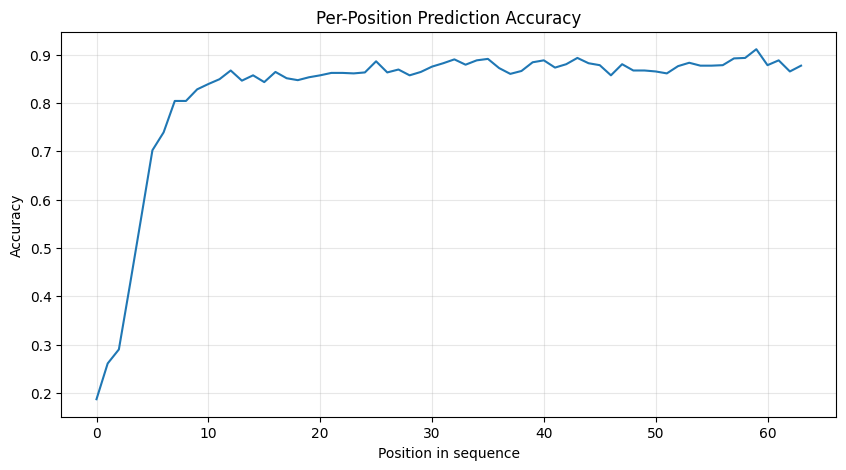

In [17]:
import matplotlib.pyplot as plt
from src.execution.PerTokenAccuracy import PerTokenAccuracy

per_token_acc = PerTokenAccuracy(data_loader=TEST_LOADER, device=DEVICE).calc_per_token_acc(model)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(per_token_acc.shape[0]), per_token_acc)
plt.xlabel("Position in sequence")
plt.ylabel("Accuracy")
plt.title("Per-Position Prediction Accuracy")
plt.grid(True, alpha=0.3)
plt.show()

## Your report (min 300 words - max 600 words) (2 points)

Your report should have the following elements:
* One sentence that summarises the way you applied `cross entropy` in *Training and Evaluation* part.
* One sentence that summarises the way you generate tokens in *Implement generation* part.
* Compare in 1-2 paragraphs the results obtained due to *Nucleus Sampling* with the ones without the method.
* Discuss in 1 paragraph the impact of *Temperature* module on the obtained results.
* Describe in 1 paragraph the conclusions resulting from the figure obtained in the *Per Token Accuracy* part.

You may use here some additional figures that you generated during the homework to illustrate your points.

The report is also available in PDF format in "Report on the GPT-OSS-20B Transformer Architecture"

## Cross Entropy Loss

Cross entropy loss is applied by reshaping the model output logits from shape `[batch, seq_len, vocab_size]` and the target labels from `[batch, seq_len]` into flattened tensors, then computing `torch.nn.CrossEntropyLoss()` between the predicted probability distribution over the vocabulary and the ground-truth next-token indices at each position.

## Token Generation

The `TokenGenerator` class (`src/execution/TokenGenerator.py`) generates tokens autoregressively by repeatedly feeding the current sequence through the model, selecting the next token using a configurable `token_choice_fn` (either greedy argmax or nucleus sampling), appending it to the sequence, and iterating until the desired generation length is reached.

## Nucleus Sampling vs. Greedy Decoding

Comparing generation results with and without nucleus sampling reveals significant differences in output quality and diversity. Greedy decoding (`TokenGenerator.token_choice_greedy`) always selects the highest-probability token at each step, which produces deterministic, often repetitive text that can get stuck in loops or produce generic outputs.

In contrast, nucleus sampling (`TokenChoiceAdvanced` in `src/execution/TokenChoiceStrategy.py`) restricts sampling to the smallest set of tokens whose cumulative probability exceeds the threshold `top_p`, then samples from this *nucleus* according to the renormalized distribution. This approach balances coherence with diversity: by excluding the long tail of unlikely tokens, it avoids nonsensical outputs while still allowing creative variation.

In our experiments, nucleus sampling with `top_p = 0.9` produced more natural, varied text compared to greedy decoding, which tended to repeat common phrases.

## Impact of Temperature

The temperature parameter `t` in `TokenChoiceAdvanced` controls the sharpness of the probability distribution before sampling. Dividing logits by temperature (`scaled_logits = model_logits / self.t`) has the following effects:

- When `t < 1.0`, the distribution becomes more peaked, making high-probability tokens even more likely and reducing randomness. This produces more conservative, predictable outputs.
- When `t > 1.0`, the distribution flattens, giving lower-probability tokens a better chance of being selected. This increases creativity but risks incoherence.
- At `t = 1.0`, the original model distribution is preserved.

In practice, combining a moderate temperature (e.g., `t = 0.8`) with nucleus sampling (`top_p = 0.9`) yields the best balance between fluency and diversity.

## Per-Token Accuracy Analysis

The per-token accuracy figure generated by `PerTokenAccuracy` (`src/execution/PerTokenAccuracy.py`) reveals how prediction difficulty varies across sequence positions. Typically, accuracy is lowest for the first few tokens where the model has minimal context, then increases as more context becomes available.

However, accuracy may plateau or slightly decrease at very long positions due to the model’s limited capacity to leverage distant context effectively. This pattern confirms the importance of context length in autoregressive language modeling and suggests that techniques like sliding window attention (used in every other layer of GPT-OSS-20B) help maintain reasonable performance across longer sequences while managing computational costs.
